# **Grad CAM and use-cases**

Import required packages

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from skimage import io
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)

Load VGG model and load image of a lion

In [ ]:
model = VGG16(weights="imagenet")


553476096/553467096 [==============================] - 6s 0us/step


Load and pre-process image of a lion

In [ ]:
lion = io.imread("https://conservationaction.co.za/wp-content/uploads/2018/08/CHAS1066.jpg")
lion = cv2.resize(lion, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(lion)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Get predictions from the model for the lion image

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


49152/35363 [=========================================] - 0s 0us/step
Predicted label: lion


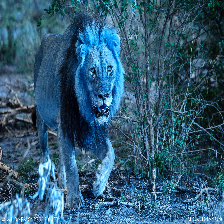

In [ ]:
preds = model.predict(x)
label = decode_predictions(preds, top=1)
class_idx = np.argmax(preds[0])
#print(class_idx)
print(f"Predicted label: {label[0][0][1]}")
class_output = model.output[:, class_idx]
cv2_imshow(lion)

Visualize last layer of model using Grad-CAM


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Generate heatmap of where exactly the model is looking at - in the final layer

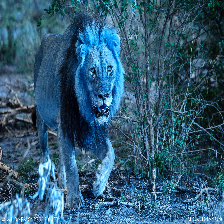

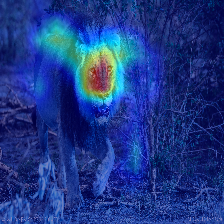

In [ ]:
# Get the heatmap
heatmap = make_gradcam_heatmap(x, model, "block5_conv2")

# Convert into JET COLORMAP (red-blue-green)
heatmap = cv2.resize(heatmap, (lion.shape[1], lion.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose onto original image
superimposed_img = cv2.addWeighted(lion, 0.5, heatmap, 0.5, 0)

# Display both the images
cv2_imshow(lion)
cv2_imshow(superimposed_img)

# **COVID-19 Classification using CNN**

Import necessary libraries

In [7]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

Prepare X-ray data

In [ ]:
#TODO: Link Google Drive and load COVID-19 XRay data from there
data_dir = "/"
os.listdir(data_dir)
train_dir = data_dir+"/train"
os.listdir(train_dir)
test_dir = data_dir+"/test"
os.listdir(test_dir)

Create test and train image generators

In [ ]:
generator = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1/255,
)

train_generator = generator.flow_from_directory (
    train_dir,
    target_size=image_size[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

test_generator = generator.flow_from_directory (
    test_dir,
    target_size=image_size[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)

Creating a CNN model from scratch

In [ ]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=6)

model = Sequential()
model.add(Conv2D(filters = 32, padding = "same", kernel_size = (2,2), strides = (2,2), activation = "relu", input_shape = image_size))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, padding = "same", kernel_size = (2,2), strides = (2,2), activation = "relu", input_shape = image_size))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, padding = "same", kernel_size = (2,2), strides = (2,2), activation = "relu", input_shape =image_size))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 132, activation = "relu"))
model.add(Dense(units = 60, activation = "relu"))
model.add(Dense(units = 3, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

TODO:

1) Link Google Drive and load COVID-19 dataset from there

2) Verify CNN model created from scratch

3) Train the model using image dataset

4) Create predication for random COVID-19 test images

5) Visualize heatmap output of model layers for XRay image

